# ***Imports***

In [138]:
import os
import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

In [139]:
import tensorflow as tf
from tensorflow.keras import layers,Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Progbar
from sklearn.model_selection import train_test_split

# ***Parameters***

In [140]:
SHAPE = (224,224)
BATCH_SIZE = 64
SEED = 42
train_path = "/kaggle/input/image-depth-estimation/data/nyu2_train"

# ***Dataset***

In [141]:
image_paths = tf.data.Dataset.list_files(train_path + '/*/*.jpg',seed=SEED) # images in colors
target_paths = tf.data.Dataset.list_files(train_path + '/*/*.png',seed=SEED)  # images with depth estimation

def preprocess(file_type) : 
    def preprocess_image(file_path):
        # Read the image file
        image = tf.io.read_file(file_path)
        # Decode the image to a tensor
        image = tf.image.decode_jpeg(image, channels=3) if file_type else tf.image.decode_png(image, channels=3)
        # Resize the image
        image = tf.image.resize(image, SHAPE)  # Set the desired new height and width
        # Normalize the image
        image = image / 255.0  # Divide by 255.0 to scale pixel values between 0 and 1
        return image
    return preprocess_image

# if True it means decode as JPG else PNG
images = image_paths.map(preprocess(True)) 
targets = target_paths.map(preprocess(False))

In [142]:
MAX_DATA = len(images)//2

images = images.take(MAX_DATA)
targets = targets.take(MAX_DATA)

images = images.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
targets = targets.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ***Showing data***

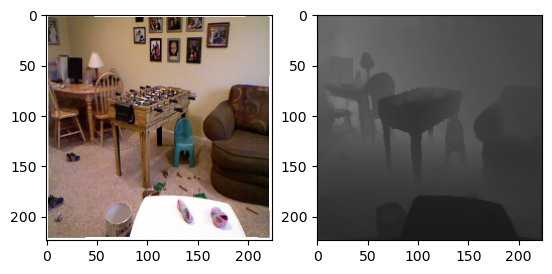

In [143]:
_,real_im = next(enumerate(images))
_,target_im = next(enumerate(targets))

nb = random.randint(0,BATCH_SIZE-1)

plt.figure()
plt.subplot(121)
plt.imshow(real_im[0])
plt.subplot(122)
plt.imshow(target_im[0])
plt.show()

# ***Spliting Data***

In [144]:
def get_train(data,train_count):
    return data.take(train_count)

def get_validation(data,train_count,val_count):
    return data.skip(train_count).take(val_count)
    
    
train_size = 0.8 
val_size = 0.2 

train_count = int(len(images) * train_size)  # Number of test samples
val_count = int(len(images) * val_size)

X_train = get_train(images,train_count)
y_train = get_train(targets,train_count)

X_test = get_validation(images,train_count,val_count)
y_test = get_validation(targets,train_count,val_count)

# ***Model***

In [145]:
class EncoderBlock(layers.Layer):
    def __init__(self,filters):
        super(EncoderBlock,self).__init__()
        
        self.conv_1 = layers.Conv2D(filters=filters,kernel_size=(3,3),strides=(1,1),padding="same")
        self.conv_2 = layers.Conv2D(filters=filters,kernel_size=(3,3),strides=(1,1),padding="same")
        
        self.bn_1 = layers.BatchNormalization()
        self.bn_2 = layers.BatchNormalization()

        self.max_pool = layers.MaxPool2D(pool_size=(2,2))
        self.relu = layers.ReLU()
        
    def call(self,X):
        X = self.conv_1(X)
        X = self.bn_1(X)
        X = self.relu(X)
        
        X = self.conv_2(X)
        X = self.bn_2(X)
        X = self.relu(X)
        
        return self.max_pool(X)

class DecoderBlock(layers.Layer) : 
    def __init__(self,filters):
        super(DecoderBlock,self).__init__()
        
        self.conv_1 = layers.Conv2D(filters=filters,kernel_size=(3,3),strides=(1,1),padding="same")
        self.conv_2 = layers.Conv2D(filters=filters,kernel_size=(3,3),strides=(1,1),padding="same")
        
        self.bn_1 = layers.BatchNormalization()
        self.bn_2 = layers.BatchNormalization()

        self.relu = layers.ReLU()
        self.up_conv = layers.UpSampling2D(size=(2,2))
        
    def call(self,X):
        X = self.conv_1(X)
        X = self.bn_1(X)
        X = self.relu(X)
        
        X = self.conv_2(X)
        X = self.bn_2(X)
        X = self.relu(X)
        
        return self.up_conv(X)

class DepthModel(Model):
    def __init__(self,image_dim=3):
        super(DepthModel,self).__init__()
        self.encoder = [
            EncoderBlock(64),       
            EncoderBlock(128),  
            EncoderBlock(256),  
            EncoderBlock(512),  
        ]
        self.decoder = [
            DecoderBlock(512),       
            DecoderBlock(256),  
            DecoderBlock(128),  
            DecoderBlock(64),  
        ]
        self.last_conv = layers.Conv2D(filters=image_dim,kernel_size=(1,1),strides=(1,1))

    def call(self,X):
        encoder_output = []
        # ----------------------------- Encoder
        for encoder in self.encoder:
            X = encoder(X)
            encoder_output.append(X)
        # ----------------------------- Decoder
        for decoder in self.decoder:
            residual_connexion = encoder_output.pop()
            X = tf.concat([residual_connexion, X], axis=-1)
            X = decoder(X)

        return self.last_conv(X)

In [146]:
LR = 1e-4
image_dim = batch_x[nb].shape[-1]
model = DepthModel(image_dim=image_dim)
opt = Adam(learning_rate=LR)

# ***Functions***

In [147]:
@tf.function
def train_step(X,target):    
    with tf.GradientTape() as tape:
        prediction = model(X)
        loss = get_loss(prediction,target)
    gradients = tape.gradient(loss,model.trainable_variables)
    opt.apply_gradients(zip(gradients,model.trainable_variables))
    return loss

@tf.function
def val_step(X,target):
    prediction = model(X)
    loss = get_loss(prediction,target)
    return loss

# Get this from Keras docs
@tf.function
def get_loss(pred,target):
    ssim_loss_weight = 0.85
    l1_loss_weight = 0.1
    edge_loss_weight = 0.9
        
    # Compare edges
    dy_true, dx_true = tf.image.image_gradients(target)
    dy_pred, dx_pred = tf.image.image_gradients(pred)
    weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
    weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

    # Depth smoothness
    smoothness_x = dx_pred * weights_x
    smoothness_y = dy_pred * weights_y
    
    depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
        abs(smoothness_y)
    )

    # Structural similarity (SSIM) Luminance/Contrast/Structural information better than MSE
    ssim_loss = tf.reduce_mean(
        1
        - tf.image.ssim(
            target, pred, max_val=SHAPE[0], filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
        )
    )
    # MAE
    l1_loss = tf.reduce_mean(tf.abs(target - pred))

    loss = (
        (ssim_loss_weight * ssim_loss)
        + (l1_loss_weight * l1_loss)
        + (edge_loss_weight * depth_smoothness_loss)
    )

    return loss

# ***Training and Validation***

In [148]:
EPOCHS = 20
show = True
training_loss = []
val_loss = []

print("[START]")
for epoch in tf.range(EPOCHS):
    batch_loss = []
    val_batch_loss = []
    
    print(f"epoch  : {epoch+1}/{EPOCHS}")
    pb_i = Progbar(len(X_train), stateful_metrics=('loss','val_loss'))
    for batch_x,batch_y in zip(X_train,y_train):
        loss = train_step(batch_x,batch_y)        
        values=[('loss',loss)]
        pb_i.add(1, values=values)
        batch_loss.append(loss)

    if show:
        print(model.summary())
        show = False
        
    for batch_x,batch_y in zip(X_test,y_test):
        loss = val_step(batch_x,batch_y)        
        val_batch_loss.append(loss)

    values=[('val_loss',loss)]
    pb_i.add(1, values=values)    
    val_loss.append(sum(val_batch_loss)/len(val_batch_loss))
    training_loss.append(sum(batch_loss)/len(batch_loss))      
    
print("\n[END]")


[START]
epoch  : 1/20
316/316 [==============================] - 271s 756ms/step - loss: 0.0732
Model: "depth_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_block_4 (EncoderBlo  multiple                 39232     
 ck)                                                             
                                                                 
 encoder_block_5 (EncoderBlo  multiple                 222464    
 ck)                                                             
                                                                 
 encoder_block_6 (EncoderBlo  multiple                 887296    
 ck)                                                             
                                                                 
 encoder_block_7 (EncoderBlo  multiple                 3544064   
 ck)                                                             
                       

In [154]:
model_path = 'depth-model'
model.save(model_path)

In [155]:
!zip -r file.zip 'depth-model'

  adding: depth-model/ (stored 0%)
  adding: depth-model/variables/ (stored 0%)
  adding: depth-model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: depth-model/variables/variables.index (deflated 75%)
  adding: depth-model/saved_model.pb (deflated 91%)
  adding: depth-model/keras_metadata.pb (deflated 94%)
  adding: depth-model/fingerprint.pb (stored 0%)
  adding: depth-model/assets/ (stored 0%)


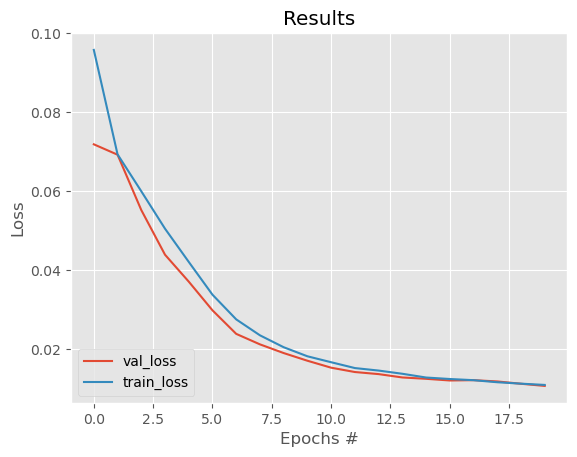

In [149]:
plt.style.use("ggplot")
plt.figure()
plt.plot(val_loss, label="val_loss")
plt.plot(training_loss, label="train_loss")
plt.title("Results")
plt.xlabel("Epochs #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plot.png")
plt.show()

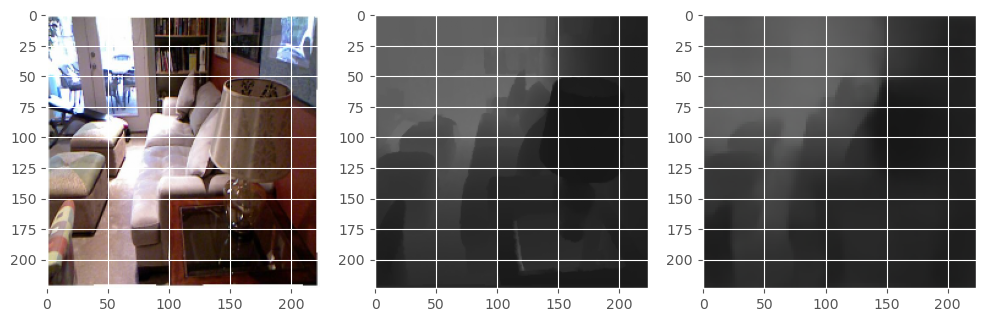

In [150]:
_,batch = next(enumerate(X_train))
_,target = next(enumerate(y_train))

image = tf.reshape(batch[0],(1,224,224,3))
prediction = model(image)
prediction = prediction[0]
prediction = np.reshape(prediction, (224, 224, 3))

plt.figure(figsize=(12,7))
plt.subplot(131)
plt.imshow(batch[0])
plt.subplot(132)
plt.imshow(target[0])
plt.subplot(133)
plt.imshow(prediction)
plt.show()

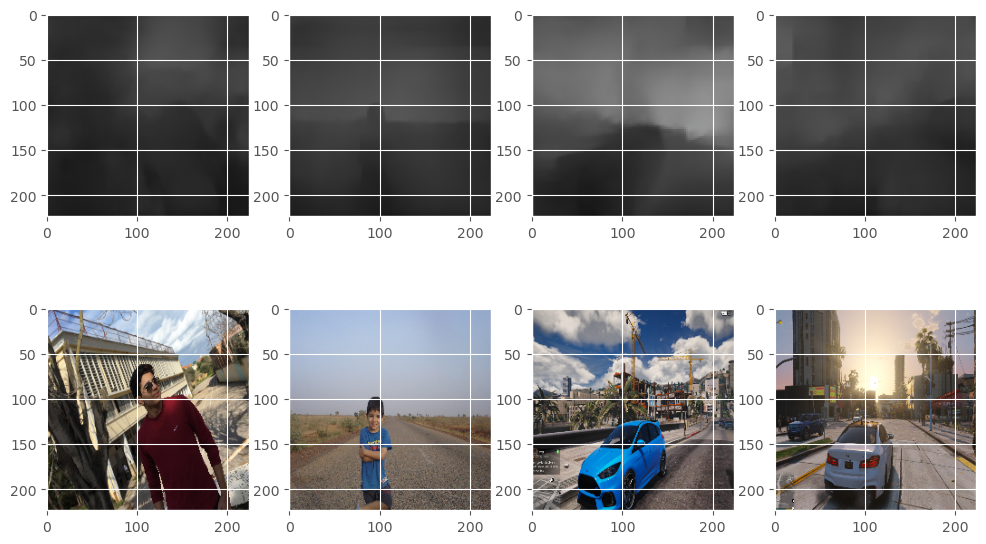

In [176]:
test_dir = glob.glob("/kaggle/input/test-set/*")
test_images = []

for path in test_dir:
    image = cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,SHAPE)
    image = tf.math.divide(image,255)
    test_images.append(image)
    
test_images = np.array(test_images)
prediction = model(test_images)
max_im = prediction.shape[0]

plt.figure(figsize=(12,7))
for i,image in enumerate(prediction) : 
    plt.subplot(2,max_im,i+1)
    plt.imshow(image)
    
for i,image in enumerate(test_images) : 
    plt.subplot(2,max_im,i+max_im+1)
    plt.imshow(image)
plt.show()